# Learning Causal Skeleton in Multivariate Setting

## Setup

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, norm
import networkx as nx

## Correlation and Partial Correlation

We use a recursive formula to compute the partial correlation. The $n$th-order partial correlation is easily calculated from three ($n-1$)th-order partial correlations.

In [2]:
def partial_corr(i, j, K, p_corr):
    """
        p_corr is a dictionary in which we store the computed correlations or partial correlations.
    """
    
    if i > j:
        i, j = j, i
    
    if (i, j, K) in p_corr:
        return p_corr[(i, j, K)]
    
    if len(K) == 0: # Simple correlation between Xi and Xj
        p_corr[(i, j, K)] = pearsonr(X[:, i], X[:, j])[0]
        return p_corr[(i, j, K)]
    
    l = K[0]
    corr_ijK = partial_corr(i, j, K[1:], p_corr)
    corr_ilK = partial_corr(i, l, K[1:], p_corr)
    corr_ljK = partial_corr(l, j, K[1:], p_corr)
    p_corr[(i, j, K)] = (corr_ijK - corr_ilK*corr_ljK) / math.sqrt((1 - corr_ilK**2) * (1 - corr_ljK**2))
    return p_corr[(i, j, K)]

## Test of Independence
For Gaussian RVs, we use Fisher's $Z$-transform:

$$z(i,j | K) = \frac{1}{2}\log\frac{1 + \hat{\rho}_{i, j | K}}{1 - \hat{\rho}_{i, j | K}}$$

$$z \sim \mathcal{N}(\frac{1}{2}\log\frac{1 + \rho_{i, j | K}}{1 - \rho_{i, j | K}}, \frac{1}{\sqrt{n-3}})$$

In [5]:
def independence(X, signf, i, j, p_corr, K = None):
    n = len(X)
    critical = norm.ppf(1 - signf/2)
    
    if K is None:
        corr = pearsonr(X[:, i], X[:, j])[0]
    
    else:
        corr = partial_corr(i, j, tuple(sorted(K)), p_corr)
        
    z = math.log((1 + corr) / (1 - corr)) / 2
    t = abs(z) / math.sqrt(1 / (n - 3))
    return t < critical

## Graph Visualization

In [4]:
def plot_skeleton(edges, vertices, algorithm):
    skeleton = nx.Graph()
    for x in vertices:
        skeleton.add_node(x)

    for i, j in edges:
        skeleton.add_edges_from([(vertices[i], vertices[j])])

    nx.draw(skeleton, with_labels=True, node_size=100, edge_color="#3c98de", width=1.5, node_color="#45ff86", node_shape="s", linewidths=20)
    plt.title("Inferred Skeleton by {}".format(algorithm))
    plt.show()

## PC Algorithm Implementation

In [6]:
def PC(X, signf):
    n, p = X.shape
    
    adj = {}
    edges = set({})
    p_corr = {}
    
    for i in range(p):
        adj[i] = set({})
        
    for i in range(p):
        for j in range(i+1, p):
            if not independence(X, signf, i, j, p_corr):
                adj[i].add(j)
                adj[j].add(i)
                edges.add((i, j))
    
    for l in range(1, p):
        new_edges = set(edges)
        
        for e in edges:
            i, j = e
            no_edge = False
            
            if len(adj[i]) > l:
                adj[i].remove(j)
                subsets = set(itertools.combinations(adj[i], l))
                adj[i].add(j)
                
                for K in subsets:
                    if independence(X, signf, i, j, p_corr, K):
                        no_edge = True
                        break
                
            if not no_edge and len(adj[j]) > l:
                adj[j].remove(i)
                subsets = set(itertools.combinations(adj[j], l))
                adj[j].add(i)
                
                for K in subsets:
                    if independence(X, signf, i, j, p_corr, K):
                        no_edge = True
                        break
            
            if no_edge:
                adj[i].remove(j)
                adj[j].remove(i)
                new_edges.remove(e)
        
        edges = new_edges
        
    return edges, adj

## Stable PC Implementation

PC-stable computes and stores all variables' adjacency sets after each new size $l$ of the conditioning sets. These stored adjacency sets are used whenever we search for conditioning sets of this given size $l$. Consequently, an edge deletion no longer affects which conditional independencies are checked for other pairs of variables at this level of $l$. In other words, at each level of $l$, PC-stable records which edges should be removed, but it removes these edges only when it goes to the next value of $l$. Besides **resolving the order-dependence in the skeleton's estimation**, PC-stable has the advantage that it is **easily parallelizable at each level of $l$**. 

In [7]:
def PC_stable(X, signf):
    n, p = X.shape
    
    adj = {}
    edges = set({})
    p_corr = {}
    
    for i in range(p):
        adj[i] = set({})
        
    for i in range(p):
        for j in range(i+1, p):
            if not independence(X, signf, i, j, p_corr):
                adj[i].add(j)
                adj[j].add(i)
                edges.add((i, j))
    
    for l in range(1, p):
        new_edges = set(edges)
        no_edge = {}
        
        for e in edges:
            i, j = e
            no_edge[e] = False
            
            if len(adj[i]) > l:
                adj[i].remove(j)
                subsets = set(itertools.combinations(adj[i], l))
                adj[i].add(j)
                
                for K in subsets:
                    if independence(X, signf, i, j, p_corr, K):
                        no_edge[e] = True
                        break
                
            if not no_edge[e] and len(adj[j]) > l:
                adj[j].remove(i)
                subsets = set(itertools.combinations(adj[j], l))
                adj[j].add(i)
                
                for K in subsets:
                    if independence(X, signf, i, j, p_corr, K):
                        no_edge[e] = True
                        break
                        
        for e in edges:
            if no_edge[e]:
                i, j = e
                adj[i].remove(j)
                adj[j].remove(i)
                new_edges.remove(e)
        
        edges = new_edges
        
    return edges, adj

## Run PC-algorithm and PC-stable on the dataset

In [8]:
data = pd.read_csv('./data/multivariate_data.csv')
X = data.values
vertices = data.columns

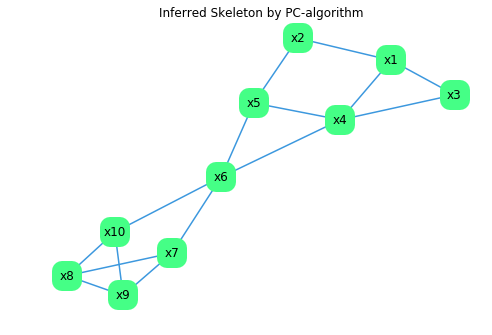

In [20]:
edges, adj = PC(X, 0.02)
plot_skeleton(edges, vertices, "PC-algorithm")

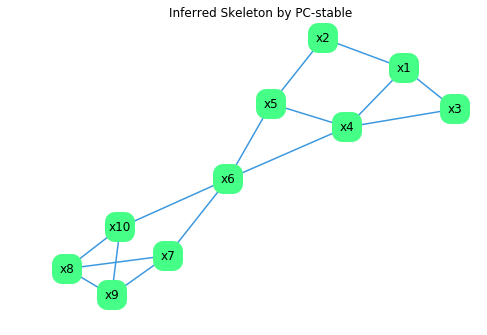

In [17]:
edges, adj = PC_stable(X, 0.02)
plot_skeleton(edges, vertices, "PC-stable")

As you see, the discovered underlying skeleton of the data by both algorithms is the same.

## Random DAG Generator

Generate a random Directed Acyclic Graph (DAG). The produced graph is topologically ordered from low to high node numbers.

In [21]:
class DAGGenerator(object):
    def __init__(self, nodes = 20, lB = 0.1, uB = 1, prob = 0.2):
        """
            nodes: number of nodes,
            lB: Lower bound of edge weights, sampled uniformly at random,
            uB: Upper bound of edge weights, sampled uniformly at random,
            prob: probability of connecting a node to another node with higher topological ordering
        """
        super(DAGGenerator, self).__init__()
        self.nodes = nodes
        self.lB = lB
        self.uB = uB
        self.prob = prob
        self.adj = np.zeros((nodes, nodes))
    
    def init_DAG(self):
        self.adj = np.zeros((self.nodes, self.nodes))
        for i in range(self.nodes):
            out_edges = np.random.binomial(1, self.prob, self.nodes-i-1)
            weights = np.random.uniform(self.lB, self.uB, self.nodes-i-1)
            self.adj[i+1:, i] = out_edges * weights
    
    def gen_data(self, n_samples = 1000):
        X = np.random.normal(size = (n_samples, self.nodes))
        for i in range(1, self.nodes):
            X[:, i] += np.sum(self.adj[i] * X, axis = 1)
        return X
    
    def rmv_DAG(self, n_samples = 1000):
        self.init_DAG()
        return self.adj, self.gen_data(n_samples)

## An Analysis of PC-pop and PC-stable on the Synthetic Data

In [22]:
def check_edges(edges, adj):
    """
        Find the number of edges that exist in both the real generative graph and the discovered graph.
    """
    correct_edges = 0
    for i, j in edges:
        if adj[i, j] != 0 or adj[j, i] != 0:
            correct_edges += 1
    return correct_edges

In [23]:
gen = DAGGenerator()
signfs = 2 ** np.linspace(-2, 1, 4) / 100

In [24]:
ave_recalls = np.zeros(shape = (len(signfs), 2))
ave_redundants = np.zeros(shape = (len(signfs), 2))

for t in range(200):
    adj, X = gen.rmv_DAG()
    recalls, redundants = [], []
    print("\n\t\t\033[94m\033[1mTest", t+1 , "\033[0m")
    
    for alpha in signfs:
        edges, _ = PC(X, alpha)
        correct1 = check_edges(edges, adj)
        recall1 = correct1 / np.count_nonzero(adj)
        redundant1 = 1 - correct1 / len(edges)
        
        edges, _ = PC_stable(X, alpha)
        correct2 = check_edges(edges, adj)
        recall2 = correct2 / np.count_nonzero(adj)
        redundant2 = 1 - correct2 / len(edges)
        
        recalls.append([recall1, recall2])
        redundants.append([redundant1, redundant2])
        
    ave_recalls += recalls
    ave_redundants += redundants
        
    recalls = pd.DataFrame(data = recalls, index = signfs, columns = ["PC-algorithm", "PC-stable"])
    recalls.index.name = "Signficance"
    
    redundants = pd.DataFrame(data = redundants, index = signfs, columns = ["PC-algorithm", "PC-stable"])
    redundants.index.name = "Signficance"
    
    print("===> Recalls\n---------------------------------------------\n", recalls)
    print("---------------------------------------------\n")
    print("===> Redundants\n---------------------------------------------\n", redundants)
    print("---------------------------------------------\n")


		Test 1 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.794118   0.794118
0.0050           0.794118   0.794118
0.0100           0.794118   0.794118
0.0200           0.794118   0.794118
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025                0.0        0.0
0.0050                0.0        0.0
0.0100                0.0        0.0
0.0200                0.0        0.0
---------------------------------------------


		Test 2 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.586957   0.586957
0.0050           0.608696   0.586957
0.0100           0.608696   0.608696
0.0200           0.608696   0.608696
-----------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.690476   0.690476
0.0050           0.714286   0.714286
0.0100           0.738095   0.738095
0.0200           0.738095   0.738095
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.033333   0.033333
0.0050           0.032258   0.032258
0.0100           0.031250   0.031250
0.0200           0.031250   0.031250
---------------------------------------------


		Test 14 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025              0.625      0.625
0.0050              0.625      0.625
0.0100              0.700      0.675
0.0200              0.700      0.700
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.651163   0.651163
0.0050           0.651163   0.651163
0.0100           0.651163   0.651163
0.0200           0.651163   0.651163
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.066667   0.034483
0.0050           0.066667   0.034483
0.0100           0.066667   0.034483
0.0200           0.066667   0.066667
---------------------------------------------


		Test 26 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.682927   0.682927
0.0050           0.682927   0.682927
0.0100           0.707317   0.707317
0.0200           0.731707   0.731707
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.644444   0.644444
0.0050           0.644444   0.644444
0.0100           0.644444   0.644444
0.0200           0.644444   0.644444
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025                0.0        0.0
0.0050                0.0        0.0
0.0100                0.0        0.0
0.0200                0.0        0.0
---------------------------------------------


		Test 38 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.677419   0.677419
0.0050           0.677419   0.677419
0.0100           0.741935   0.741935
0.0200           0.741935   0.741935
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.547619   0.547619
0.0050           0.547619   0.547619
0.0100           0.547619   0.547619
0.0200           0.595238   0.595238
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.041667        0.0
0.0050           0.041667        0.0
0.0100           0.041667        0.0
0.0200           0.038462        0.0
---------------------------------------------


		Test 50 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.714286   0.714286
0.0050           0.714286   0.714286
0.0100           0.714286   0.714286
0.0200           0.714286   0.714286
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025            0.81250    0.81250
0.0050            0.81250    0.81250
0.0100            0.81250    0.81250
0.0200            0.84375    0.84375
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025                0.0        0.0
0.0050                0.0        0.0
0.0100                0.0        0.0
0.0200                0.0        0.0
---------------------------------------------


		Test 62 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.666667   0.666667
0.0050           0.666667   0.666667
0.0100           0.666667   0.666667
0.0200           0.666667   0.666667
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025               0.56       0.54
0.0050               0.56       0.54
0.0100               0.60       0.58
0.0200               0.62       0.60
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.034483   0.035714
0.0050           0.034483   0.035714
0.0100           0.062500   0.064516
0.0200           0.060606   0.062500
---------------------------------------------


		Test 74 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.564103   0.538462
0.0050           0.564103   0.589744
0.0100           0.564103   0.564103
0.0200           0.589744   0.589744
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.888889   0.851852
0.0050           0.888889   0.851852
0.0100           0.888889   0.888889
0.0200           0.888889   0.888889
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025                0.0        0.0
0.0050                0.0        0.0
0.0100                0.0        0.0
0.0200                0.0        0.0
---------------------------------------------


		Test 86 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.780488   0.780488
0.0050           0.804878   0.804878
0.0100           0.829268   0.829268
0.0200           0.829268   0.829268
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.590909   0.590909
0.0050           0.613636   0.613636
0.0100           0.613636   0.613636
0.0200           0.636364   0.636364
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025                0.0        0.0
0.0050                0.0        0.0
0.0100                0.0        0.0
0.0200                0.0        0.0
---------------------------------------------


		Test 98 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.806452   0.806452
0.0050           0.838710   0.838710
0.0100           0.838710   0.838710
0.0200           0.838710   0.838710
---------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.764706   0.764706
0.0050           0.794118   0.794118
0.0100           0.794118   0.794118
0.0200           0.823529   0.823529
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.037037   0.037037
0.0050           0.035714   0.035714
0.0100           0.035714   0.035714
0.0200           0.034483   0.034483
---------------------------------------------


		Test 110 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.638298   0.638298
0.0050           0.638298   0.638298
0.0100           0.617021   0.617021
0.0200           0.659574   0.638298
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.783784   0.756757
0.0050           0.783784   0.756757
0.0100           0.810811   0.810811
0.0200           0.810811   0.810811
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.033333        0.0
0.0050           0.033333        0.0
0.0100           0.032258        0.0
0.0200           0.032258        0.0
---------------------------------------------


		Test 122 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025            0.87500    0.87500
0.0050            0.90625    0.90625
0.0100            0.93750    0.93750
0.0200            0.93750    0.93750
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.574468   0.574468
0.0050           0.574468   0.574468
0.0100           0.574468   0.574468
0.0200           0.595745   0.595745
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.068966   0.068966
0.0050           0.068966   0.068966
0.0100           0.068966   0.068966
0.0200           0.125000   0.096774
---------------------------------------------


		Test 134 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.774194   0.774194
0.0050           0.806452   0.806452
0.0100           0.806452   0.806452
0.0200           0.870968   0.870968
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.648649   0.648649
0.0050           0.702703   0.702703
0.0100           0.702703   0.702703
0.0200           0.729730   0.729730
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.076923   0.040000
0.0050           0.071429   0.037037
0.0100           0.071429   0.037037
0.0200           0.100000   0.035714
---------------------------------------------


		Test 146 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.666667   0.666667
0.0050           0.666667   0.666667
0.0100           0.666667   0.666667
0.0200           0.666667   0.666667
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.521739   0.521739
0.0050           0.543478   0.521739
0.0100           0.543478   0.521739
0.0200           0.565217   0.543478
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.111111   0.000000
0.0050           0.074074   0.040000
0.0100           0.074074   0.040000
0.0200           0.071429   0.038462
---------------------------------------------


		Test 158 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.604651   0.604651
0.0050           0.627907   0.627907
0.0100           0.651163   0.651163
0.0200           0.651163   0.651163
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.666667   0.666667
0.0050           0.666667   0.666667
0.0100           0.666667   0.666667
0.0200           0.692308   0.692308
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.037037   0.037037
0.0050           0.037037   0.037037
0.0100           0.037037   0.037037
0.0200           0.035714   0.035714
---------------------------------------------


		Test 170 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025              0.600       0.60
0.0050              0.625       0.60
0.0100              0.675       0.65
0.0200              0.700       0.70
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.916667   0.916667
0.0050           0.958333   0.958333
0.0100           1.000000   1.000000
0.0200           1.000000   1.000000
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025               0.00       0.00
0.0050               0.00       0.00
0.0100               0.04       0.04
0.0200               0.04       0.04
---------------------------------------------


		Test 182 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.709677   0.709677
0.0050           0.741935   0.774194
0.0100           0.741935   0.774194
0.0200           0.741935   0.774194
--------------------------------------------

===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025              0.625      0.625
0.0050              0.625      0.625
0.0100              0.625      0.625
0.0200              0.625      0.625
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.000000   0.000000
0.0050           0.000000   0.000000
0.0100           0.038462   0.038462
0.0200           0.038462   0.038462
---------------------------------------------


		Test 194 
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.810811   0.783784
0.0050           0.810811   0.783784
0.0100           0.837838   0.837838
0.0200           0.837838   0.837838
--------------------------------------------

In [25]:
recalls = pd.DataFrame(data = ave_recalls / 200, index = signfs, columns = ["PC-algorithm", "PC-stable"])
recalls.index.name = "Signficance"

redundants = pd.DataFrame(data = ave_redundants / 200, index = signfs, columns = ["PC-algorithm", "PC-stable"])
redundants.index.name = "Signficance"

print("\n\t\t\033[94m\033[1mAverage Result\033[0m")
print("===> Recalls\n---------------------------------------------\n", recalls)
print("---------------------------------------------\n")
print("===> Redundants\n---------------------------------------------\n", redundants)
print("---------------------------------------------\n")


		Average Result
===> Recalls
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.690643   0.682904
0.0050           0.701950   0.693312
0.0100           0.712259   0.703909
0.0200           0.724328   0.716602
---------------------------------------------

===> Redundants
---------------------------------------------
              PC-algorithm  PC-stable
Signficance                         
0.0025           0.024118   0.018158
0.0050           0.025531   0.018601
0.0100           0.027586   0.021198
0.0200           0.031899   0.022433
---------------------------------------------



## Conclusion

Averagely, PC-stable finds slightly fewer edges that are not in the real graph (i.e., redundants) than PC-pop. However, PC-pop achieves a moderately higher recall. That's because in every edge-checking in PC-stable, the current skeleton likely has more edges; thus, PC-stable searches for more conditioning sets to remove any edge.